# Tabular Results

This notebook allows us to query tabular results via [`mlflow`](https://mlflow.org/). As a prerequisite, the experiments have to be performed in a first step. If this is the case, we can load the results for the different tables in the accompanied article. Update the `mlruns_path` to the path used in your config file [`experiment.yaml`](../conf/experiment.yaml).

In [36]:
import os
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from hydra.utils import to_absolute_path
from mlflow import set_tracking_uri, get_experiment_by_name, search_runs

# Set global plotting style.
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

colors = [
    (0.0, (0, 128/255, 128/255)),          # teal
    (0.5, (0.8, 0.8, 0.8)),               # gray midpoint
    (1.0, (127/255, 0, 127/255)),         # purple
]

custom_cmap = LinearSegmentedColormap.from_list("MidGrayPurpleTeal", colors)

# Global constants (adjust as needed)
MLRUNS_PATH = "/mnt/work/mherde/maml/crowd_opt_sobol/"
CACHE_PATH = (
    "/mnt/home/mherde/projects/github/multi-annotator-machine-learning/empirical_evaluation/python_scripts/results_sobol"
)

# Increase maximum number of displayed rows.
pd.set_option("display.max_rows", 1000)

# Flags for output formatting
SHOW_LATEX = True
SHOW_INDIVIDUAL_SCORES = True

# Default column renaming mapping
UPDATE_COLUMNS = {
    "params.data.optimizer.gt_params.lr": "gt_lr",
    "params.data.optimizer.gt_params.weight_decay": "gt_wd",
    "params.data.optimizer.ap_params.lr": "ap_lr",
    "params.data.optimizer.ap_params.weight_decay": "ap_wd",
    "params.data.train_batch_size": "bs",
    "params.architecture.params.dropout_rate": "dr",
    "params.classifier.params.lmbda": "lmbda",
    "params.classifier.params.eta": "eta",
    "params.classifier.params.alpha": "alpha",
    "params.classifier.params.beta": "beta",
    "params.classifier.embed_size": "dim",
    "params.classifier.params.epsilon": "epsilon",
}
INV_UPDATE_COLUMNS = {v: k for k, v in UPDATE_COLUMNS.items()}

APPROACHES = [
    "ground-truth",
    "majority-vote",
    "dawid-skene",
    "crowd-layer",
    "trace-reg",
    "conal",
    "union-net-a",
    "union-net-b",
    "madl",
    "geo-reg-w",
    "geo-reg-f",
    "crowd-ar",
    "annot-mix",
    "coin-net",
]

DATASETS = [
    "sentiment_polarity",
    "music_genres",
    "reuters",
    "label_me",
    "dopanim_worst-1",
    "dopanim_worst-2",
    "dopanim_worst-var",
    "dopanim_rand-1",
    "dopanim_rand-2",
    "dopanim_rand-var",
    "dopanim_full",
    #"cifar_10_n_worst",
    #"cifar_10_n_rand-a",
    #"cifar_10_n_full",
    #"cifar_100_n",
]

LOSS_FUNC = "zero_one_loss"

def process_df(df, clf_col='clf', agg_col='agg'):
    """
    Process a DataFrame by combining classifier and aggregator columns, cleaning specific substrings, 
    dropping the aggregator column, and reordering columns.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing at least the columns specified by `clf_col` and `agg_col`.
    clf_col : str, optional
        The name of the classifier column. Default is 'clf'.
    agg_col : str, optional
        The name of the aggregator column. Default is 'agg'.

    Returns
    -------
    pandas.DataFrame
        The processed DataFrame with a combined column (named after `clf_col`) placed at the beginning, 
        with the original `agg_col` column removed and specific substrings ('aggregate_' and '_None') replaced 
        with empty strings.
    """

    # Reorder columns so that the combined column comes first
    cols = [clf_col] + [col for col in df.columns if col != clf_col]
    return df[cols]

def evaluate(
    mlruns_path: str,
    experiment_name: str,
    update_columns: dict = None,
    perf_type: str = "gt",
    version: str = "test",
    metric: str = "acc",
    epoch: str = "best",
    loss_func: str = "zero_one_loss",
    print_number_of_runs: bool = False,
    cache_path: Optional[str] = None,
):
    """
    Queries the evaluation results via mlflow.

    Parameters
    ----------
    mlruns_path : str
        Path to the results saved via mlflow.
    experiment_name : str
        Name of the mlflow experiment.
    update_columns : dict, default=None
        Optional dictionary of columns to be included in the output table.
        If None, the global UPDATE_COLUMNS is used.
    perf_type : str, default="gt"
        'gt' for ground-truth estimates or 'ap' for annotator performance estimates.
    version : str, default="test"
        One of 'train', 'valid', or 'test' for different data subsets.
    metric : str, default="acc"
        Performance metric: 'acc', 'brier_score', or 'tce'.
    epoch : str, default="best"
        Either 'last' or 'best' epoch.
    print_number_of_runs : bool, default=False
        Whether to print the count of runs per classifier.
    cache_path : Optional[str], default=None
        If provided, results are cached/read from the given path.

    Returns
    -------
    runs: pd.DataFrame or None
        Table of results or None if no experiment/runs found.
    """
    # Use the provided update_columns or fall back to the default global constant.
    if update_columns is None:
        update_columns = UPDATE_COLUMNS.copy()

    # Set mlflow tracking URI.
    abs_mlruns_path = to_absolute_path(mlruns_path)
    set_tracking_uri(uri=f"file://{abs_mlruns_path}")

    exp = get_experiment_by_name(experiment_name)
    if exp is None:
        return None

    query = "status = 'FINISHED'"
    runs = None

    # Attempt to load from cache if available.
    if cache_path:
        cache_file = os.path.join(cache_path, f"{experiment_name}.csv")
        if os.path.isfile(cache_file):
            runs = pd.read_csv(cache_file)

    # If not cached, query mlflow.
    if runs is None:
        runs = search_runs(experiment_ids=exp.experiment_id, filter_string=query, output_format="pandas")
        if runs.empty:
            return None
        if cache_path:
            try:
                runs.to_csv(cache_file, index=False)
            except Exception as e:
                print(f"Warning: Unable to cache results due to error: {e}")

    # Base column renaming.
    rename_columns = {
        "params.data.class_definition._target_": "data",
        "params.classifier.name": "clf",
        "params.classifier.aggregation_method": "agg",
    }
    # Update renaming mapping if provided columns exist in runs.
    for col, new_name in update_columns.items():
        if col in runs.columns:
            rename_columns[col] = new_name

    # Build aggregation dictionary.
    agg_dict = {
        f"metrics.{perf_type}_true_{loss_func}_{epoch}_test": ["mean", "std"],
        "params.seed": ["sum"],
    }
    bayes_columns = []
    for col in runs.columns:
        if col.startswith("metrics.") and col.endswith("_valid") and loss_func in col and "bayes" not in col:
            agg_dict[col] = ["mean", "std"]

    # Drop duplicates using selected columns.
    # Note: Ensure that 'params.data.class_definition.realistic_split' exists in runs.
    dup_keys = list(rename_columns.keys()) + ["params.seed", "params.data.class_definition.realistic_split"]
    runs = runs.drop_duplicates(subset=dup_keys)#.fillna(np.inf)
    
    if print_number_of_runs:
        # Actually print the value counts.
        print(runs["params.classifier.name"].value_counts())

    runs = runs.sort_values(by="params.seed")
    runs = runs.groupby(list(rename_columns.keys()), as_index=False, dropna=False).agg(agg_dict, skipna=False)

    # Flatten multi-index columns if necessary.
    if isinstance(runs.columns, pd.MultiIndex):
        runs.columns = ["".join(map(str, col)).strip() for col in runs.columns.values]

    # Round 'metrics' columns for accuracy if they exist.
    for col in runs.columns:
        if col.startswith("metrics") and "zero_one_loss" in col:
            runs[col] = np.round(runs[col] * 100, 3)

    # Add an extra column mapping.
    rename_columns["params.seedsum"] = "n_runs"

    # Build a combined renaming mapping for any remaining columns.
    additional_rename = {
        col: col.replace("mean", "")
        .replace("max", "")
        .replace("std", "_std")
        .replace("-", "_")
        .replace("metrics.", "")
        for col in runs.columns
        if col not in rename_columns
    }
    # Merge both dictionaries. (Note: The "|" operator requires Python 3.9+)
    full_rename = rename_columns | additional_rename
    runs = runs.rename(columns=full_rename)
    return runs

def plot_rankings(ranking_df, file_path, approaches_key="clf"):
    metrics = [f"{c.replace('_', '-').replace('-target', '')}" for c in ranking_df.columns[1:]]
    approaches = ranking_df[approaches_key].values
    ranking_matrix = ranking_df[ranking_df.columns[1:]].values.round(2)

    plt.figure(figsize=(12, 12))
    plt.imshow(ranking_matrix, cmap=custom_cmap, vmin=0, vmax=1, alpha=0.7)
    for i in range(ranking_matrix.shape[0]):
        for j in range(ranking_matrix.shape[1]):
            formatted_text = r'${:.2f}$'.format(ranking_matrix[i, j]).replace("$nan$", "N/A")
            plt.text(j, i, formatted_text, ha="center", va="center", color="black", fontsize=16)#, bbox=dict(facecolor='white', edgecolor='none', pad=0))
    plt.xticks(np.arange(len(metrics)), metrics, rotation=90)
    plt.yticks(np.arange(len(approaches)), approaches)
    #plt.colorbar()
    plt.savefig(file_path)
    plt.show()

## Hyperparameter Study

Load the table with the results of the hyperparameter study with the ground truth model.

In [40]:
df_dict = {}
approach_rankings = None
metric_rankings = None
for ds in DATASETS:
    print(ds)
    results_df_dict = {}
    for experiment_type in ["standard", "default", "hyperparameter_search"]:
        # Load results per dataset.
        exp_name = f"{experiment_type}_{ds}"
        runs_df = evaluate(
            mlruns_path=os.path.join(MLRUNS_PATH, exp_name),
            experiment_name=exp_name,
            update_columns=UPDATE_COLUMNS,
            perf_type="class",
            version="valid",
            epoch="last",
            loss_func=LOSS_FUNC,
            cache_path=CACHE_PATH,
        )
        if runs_df is not None:

            # Preprocess columns.
            df = runs_df.drop(columns=["data"])
            df['clf'] = df['clf'].astype(str) + '-' + df['agg'].astype(str)
            df.drop(columns=['agg'], inplace=True)

            # Identify '_valid' columns & rank them within each group
            target_col = f"class_true_{LOSS_FUNC}_last_test"
            group_cols = ["clf"]
            valid_cols = [c for c in df.columns if c.endswith("valid")]

            if SHOW_INDIVIDUAL_SCORES:

                # Identify non-valid and group columns
                other_cols = [col for col in df.columns if not col.endswith("valid") and col not in group_cols]

                # Function that, for each group, returns rows corresponding 
                # to the max values for each "valid" column.
                def get_max_rows(grp):
                    d = {}
                    for col in valid_cols:
                        idx = grp[col].idxmin()
                        if not np.isnan(idx):
                            d[col] = grp.loc[idx, other_cols]
                    return pd.DataFrame(d).T

                # Apply to each group
                df_max = df.groupby(group_cols).apply(get_max_rows)

                # df_max now has a multi-index with the group keys + the valid column name
                # If you want a flat DataFrame, reset the index and rename columns
                df_max = df_max.reset_index()
                df_max.columns = group_cols + ["valid_col"] + other_cols
                df_max = df_max.sort_values(by=["clf", f"class_true_{LOSS_FUNC}_last_test"])
                df_max["rank"] = df_max.groupby("clf")[f"class_true_{LOSS_FUNC}_last_test"].rank(
                    ascending=True, pct=True, method="dense"
                )
                df_max = df_max[(df_max["clf"] == "aggregate-ground-truth") & (df_max["valid_col"] == f"class_true_{LOSS_FUNC}_last_valid")]
                df_max = df_max.rename(columns=INV_UPDATE_COLUMNS)
                drop_col = [c for c in df_max.columns if not "params" in c]
                df_max = df_max.drop(columns=drop_col)
                df_max = df_max.dropna(axis=1)
                #print(df_max.to_markdown(tablefmt="github"))
                print(df_max.to_dict("list"))
                continue


            for col in valid_cols:
                df[col + "_rank"] = df.groupby(group_cols)[col].rank(method="dense")

            # Define subsets & compute mean rank per subset
            subsets = {
                # Lower and upper baseline scores.
                "true": [f"class_true_{LOSS_FUNC}_last_valid"],
                "agg": [f"class_mv_unif_{LOSS_FUNC}_last_valid"],
                "cld": [f"annot_unif_{LOSS_FUNC}_last_valid"],
                #"agg-cld": [
                #    "class_mv_unif_{LOSS_FUNC}_last_valid",
                #    "annot_unif_{LOSS_FUNC}_last_valid"
                #],

                # Performance-based scores without weights.
                "agg-perf": [f"class_mv_perf_{LOSS_FUNC}_last_valid"],
                #"agg-cld-perf": [
                #    "class_mv_perf_{LOSS_FUNC}_last_valid",
                #    "annot_unif_{LOSS_FUNC}_last_valid"
                #],
                #"full-perf": [
                #    "class_mv_perf_{LOSS_FUNC}_last_valid",
                #    "annot_unif_{LOSS_FUNC}_last_valid",
                #    "class_mv_unif_{LOSS_FUNC}_last_valid"
                #],

                # Performance-based scores with weights.
                "w-agg-perf": [f"class_mv_perf_weights_{LOSS_FUNC}_last_valid"],
                "w-cld-perf": [f"annot_perf_weights_{LOSS_FUNC}_last_valid"],
                #"w-agg-cld-perf": [
                #    "class_mv_perf_weights_{LOSS_FUNC}_last_valid",
                #    "annot_perf_weights_{LOSS_FUNC}_last_valid",
                #],
                #"w-full-perf": [
                #    "annot_perf_weights_{LOSS_FUNC}_last_valid",
                #    "class_mv_perf_weights_{LOSS_FUNC}_last_valid",
                #    "class_mv_unif_{LOSS_FUNC}_last_valid",
                #],
                "full": [
                    f"class_mv_unif_{LOSS_FUNC}_last_valid",
                    f"annot_unif_{LOSS_FUNC}_last_valid",
                    f"class_mv_perf_{LOSS_FUNC}_last_valid",
                    f"class_mv_perf_weights_{LOSS_FUNC}_last_valid",
                    f"annot_perf_weights_{LOSS_FUNC}_last_valid",
                ]

            }
            for subset_name, subset_cols in subsets.items():
                rank_cols = [c + "_rank" for c in subset_cols]
                df[f"{subset_name}_mean_rank"] = df[rank_cols].mean(axis=1, skipna=False)
                # Weighted average (row-wise):
                # weighted_mean = sum(w_i * x_i) / sum(w_i)
                # weight_cols = [c + "_std" for c in subset_cols]
                # ranks = df[rank_cols].values
                # weights = np.exp(-df[weight_cols].values)
                # df[f"{subset_name}_mean_rank"] = (ranks * weights).sum(axis=1) / weights.sum(axis=1)

            # Start with a DataFrame of unique group columns.
            results_df_dict[experiment_type] = {
                "mean": df.drop_duplicates(group_cols)[group_cols].sort_values(group_cols).reset_index(drop=True)
            }
            results_df_dict[experiment_type]["std"] = results_df_dict[experiment_type]["mean"].copy()

            # Loop over subsets to find best row -> then attach the 'target'.        
            for subset_name in subsets:
                mean_rank_col = f"{subset_name}_mean_rank"
                best_idx = df.groupby(group_cols)[mean_rank_col].idxmin().dropna()

                # Extract columns for merging, rename 'target' -> subset-specific
                best_for_subset = df.loc[best_idx, group_cols + [target_col]].copy()
                best_for_subset.rename(columns={target_col: f"{subset_name}_target"}, inplace=True)
                results_df_dict[experiment_type]["mean"] = results_df_dict[experiment_type]["mean"].merge(best_for_subset, on=group_cols, how="left")

                best_for_subset = df.loc[best_idx, group_cols + [target_col + "_std"]].copy()
                best_for_subset.rename(columns={target_col + "_std": f"{subset_name}_target"}, inplace=True)
                results_df_dict[experiment_type]["std"] = results_df_dict[experiment_type]["std"].merge(best_for_subset, on=group_cols, how="left")

            # Reformat resulting data frames.
            for k in results_df_dict[experiment_type].keys():
                results_df_dict[experiment_type][k].columns = [f"{c.replace('_', '-').replace('-target', '')}" for c in results_df_dict[experiment_type][k].columns]
                results_df_dict[experiment_type][k]['clf'] = results_df_dict[experiment_type][k]['clf'].replace({"aggregate-": "", "-None": "", "_": "-"}, regex=True)
                results_df_dict[experiment_type][k]['sort_key'] = results_df_dict[experiment_type][k]['clf'].apply(lambda x: APPROACHES.index(x))
                results_df_dict[experiment_type][k] = results_df_dict[experiment_type][k].sort_values('sort_key').drop(columns='sort_key')
                results_df_dict[experiment_type][k] = results_df_dict[experiment_type][k].set_index(["clf"])
    if SHOW_INDIVIDUAL_SCORES:
        continue
    perf_cols = ["def", "def-oracle"] + list(subsets.keys())
    perf_cols[0] = "true"
    perf_cols[2] = "def"
    results_df_dict["hyperparameter_search"]["mean"]["def"] = results_df_dict["standard"]["mean"]["true"].values
    results_df_dict["hyperparameter_search"]["std"]["def"] = results_df_dict["standard"]["std"]["true"].values
    results_df_dict["hyperparameter_search"]["mean"]["def-oracle"] = results_df_dict["default"]["mean"]["true"].values
    results_df_dict["hyperparameter_search"]["std"]["def-oracle"] = results_df_dict["default"]["std"]["true"].values
    results_df_dict = {"mean": results_df_dict["hyperparameter_search"]["mean"].reindex(perf_cols, axis=1), "std": results_df_dict["hyperparameter_search"]["std"].reindex(perf_cols, axis=1)}
    df_dict[ds] = results_df_dict
    
    # Print results as markdown.
    df_markdown = results_df_dict["mean"].applymap(lambda x: f"{x:.2f}" if isinstance(x, (float, int)) else x) + " ± " + results_df_dict["std"].applymap(lambda x: f"{x:.2f}" if isinstance(x, (float, int)) else x)
    print(df_markdown.to_markdown(tablefmt="github", floatfmt=".4f"))

    if SHOW_LATEX:
        df_latex = results_df_dict["mean"].applymap(lambda x: f"${x:.2f}" if isinstance(x, (float, int)) else x) + "_{\pm " + results_df_dict["std"].applymap(lambda x: f"{x:.2f}" + "}$" if isinstance(x, (float, int)) else x)
        df_latex.index = df_latex.index.map(lambda x: f"\\texttt{{{x}}}")
        df_latex = df_latex.replace("$nan_{\pm nan}$", "--")
        #print(df_latex.style.to_latex())

        # Get the underlying DataFrames for means and standard deviations
        mean_df = results_df_dict["mean"]
        std_df = results_df_dict["std"]

        # Compute the minimum value for each column (all columns)
        col_min = mean_df[1:].min()

        # Compute the minimum for each row only considering columns starting from the third column
        row_min = mean_df.iloc[:, 1:].min(axis=1)

        # Create a copy to store our LaTeX formatted strings
        df_latex = mean_df.copy()

        # Iterate over every cell to apply the formatting
        for i in mean_df.index:
            for j in mean_df.columns:
                m_val = mean_df.loc[i, j]
                s_val = std_df.loc[i, j]
                if isinstance(m_val, (int, float)):
                    # Format the mean value with two decimals
                    formatted_mean = f"{m_val:.2f}"
                    # Bold if it is the minimum in its column
                    is_bold = m_val == col_min[j]
                    # Underline only if this column is not one of the first two
                    col_index = mean_df.columns.get_loc(j)
                    is_underline = (col_index >= 1) and (m_val == row_min[i])

                    # Apply nested formatting if both conditions hold
                    if is_bold and is_underline:
                        formatted_mean = f"\\underline{{\\color{{yescolor}}{formatted_mean}}}"
                    elif is_bold:
                        formatted_mean = f"\\color{{yescolor}}{formatted_mean}"
                    elif is_underline:
                        formatted_mean = f"\\underline{{{formatted_mean}}}"

                    # Format the standard deviation value
                    formatted_std = f"{s_val:.2f}" if isinstance(s_val, (int, float)) else s_val
                    # Combine into one LaTeX math mode string
                    df_latex.loc[i, j] = f"${formatted_mean}_{{\\pm {formatted_std}}}$"
                else:
                    df_latex.loc[i, j] = m_val

        # Format the index using typewriter font
        df_latex.index = df_latex.index.map(lambda x: f"\\texttt{{{x}}}")

        # Replace any problematic nan strings with a placeholder
        df_latex = df_latex.replace("$nan_{\\pm nan}$", "--")

        # Print the LaTeX output from the styled DataFrame
        print(df_latex.style.to_latex())
        
    # For each performance metric, compute the rank.
    approach_rankings = {metric: {} for metric in perf_cols} if approach_rankings is None else approach_rankings
    for metric in perf_cols:
        results_df_dict["mean"][f'{metric}_rank'] = results_df_dict["mean"][metric].rank(method='average', pct=True)

    # For each metric, rank the approaches.
    for key, row in results_df_dict["mean"].iterrows():
        for metric in perf_cols:
            if key not in approach_rankings[metric]:
                approach_rankings[metric][key] = []
            approach_rankings[metric][key].append(row[f'{metric}_rank'])

    # For each approach, rank its performance metrics.
    metric_rankings = {} if metric_rankings is None else metric_rankings
    grouped = results_df_dict["mean"].groupby(group_cols)[perf_cols].mean().reset_index()
    grouped['sort_key'] = grouped['clf'].apply(lambda x: APPROACHES.index(x))
    grouped = grouped.sort_values('sort_key').drop(columns='sort_key')
    for approach, row in grouped.iterrows():
        approach = row["clf"]
        perf_values = row[perf_cols]
        metric_ranks = perf_values.rank(method='average', pct=True)
        if approach not in metric_rankings:
            metric_rankings[approach] = {metric: [] for metric in perf_cols}
        for metric in perf_cols:
            metric_rankings[approach][metric].append(metric_ranks[metric])
                
# Plot ranking of approaches per metric.
final_rankings = [
    {
        'clf': key,
        **{metric: np.mean(approach_rankings[metric][key]) for metric in perf_cols}
    }
    for key in approach_rankings[perf_cols[0]].keys() if key != "ground-truth"
]
final_rank_df = pd.DataFrame(final_rankings)
print("Average approach ranking (from approach_rankings)")
plot_rankings(final_rank_df, file_path=f"ranking_metrics_{LOSS_FUNC}.pdf")

# Plot ranking of metrics per approach.
final_data = [
    {
        'clf': key,
        **{metric: np.mean(metric_dict[metric]) for metric in perf_cols}
    }
    for key, metric_dict in metric_rankings.items() if key != "ground-truth"
]
final_rank_df = pd.DataFrame(final_data)
print("Average approach ranking (from metric_rankings)")
plot_rankings(final_rank_df, file_path=f"ranking_approaches_{LOSS_FUNC}.pdf")

sentiment_polarity
{'params.data.optimizer.gt_params.lr': [0.001], 'params.data.optimizer.gt_params.weight_decay': [0.0], 'params.data.optimizer.ap_params.lr': [0.001], 'params.data.optimizer.ap_params.weight_decay': [0.0], 'params.data.train_batch_size': [32], 'params.architecture.params.dropout_rate': [0.25], 'params.classifier.params.alpha': [0.0]}
{'params.data.optimizer.gt_params.lr': [0.0046863603947399], 'params.data.optimizer.gt_params.weight_decay': [0.0001992551543513], 'params.data.optimizer.ap_params.lr': [0.0046863603947399], 'params.data.optimizer.ap_params.weight_decay': [0], 'params.data.train_batch_size': [32], 'params.architecture.params.dropout_rate': [0.4725517425686121], 'params.classifier.params.alpha': [0.0]}
{'params.data.optimizer.gt_params.lr': [0.0046863603947399], 'params.data.optimizer.gt_params.weight_decay': [0.0001992551543513], 'params.data.optimizer.ap_params.lr': [0.0046863603947399], 'params.data.optimizer.ap_params.weight_decay': [0], 'params.data.t

TypeError: 'NoneType' object is not subscriptable

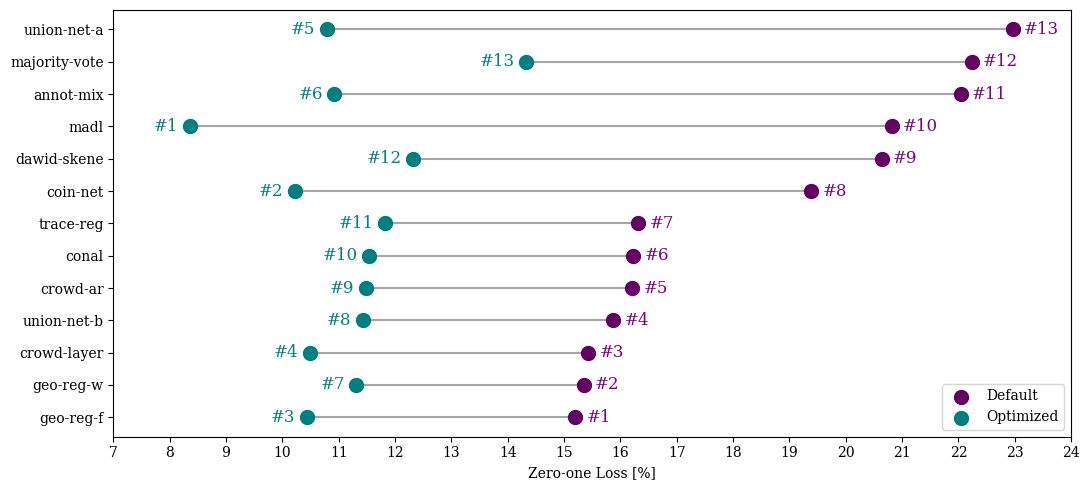

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate performance data for 12 approaches.
np.random.seed(0)
approaches = APPROACHES[1:]

# labelme
default_performance = np.array([18.27, 15.32, 14.68, 15.99, 15.67, 14.48, 15.25, 15.99, 15.25, 15.03, 15.47, 15.74, 13.05])
optimized_performance = np.array([14.54, 13.20, 15.10, 13.54, 14.85, 13.74, 13.72, 13.35, 13.65, 13.10, 14.81, 14.71, 14.21])

# reuters
default_performance = np.array([22.24, 20.64, 15.43, 16.32, 16.23, 22.96, 15.87, 20.82, 15.35, 15.20, 16.21, 22.04, 19.39])
optimized_performance = np.array([14.77, 12.32, 10.49, 11.83, 11.80, 12.27, 11.43, 8.36, 11.31, 11.24, 11.14, 12.94, 10.22])
optimized_performance = np.array([14.33, 12.32, 10.49, 11.83, 11.54, 10.79, 11.43, 8.36, 11.31, 10.43, 11.48, 10.92, 10.22])


# Compute rankings (1=best) based on performance (higher is better).
default_rank = np.argsort(default_performance).argsort() + 1
optimized_rank = np.argsort(optimized_performance).argsort() + 1

# Sort approaches by default performance for clearer visualization.
order = np.argsort(default_performance)
approaches_sorted = np.array(approaches)[order]
default_sorted = default_performance[order]
optimized_sorted = optimized_performance[order]
default_rank_sorted = default_rank[order]
optimized_rank_sorted = optimized_rank[order]

fig, ax = plt.subplots(figsize=(11, 5))

# Plot dumbbell lines for performance gain.
ax.hlines(y=approaches_sorted, xmin=default_sorted, xmax=optimized_sorted, color='gray', alpha=0.7, zorder=-3)

# Annotate each marker with its ranking.
for i, approach in enumerate(approaches_sorted):
    # Annotate the default performance marker with its rank.
    ax.text(default_sorted[i] + 0.2, approaches_sorted[i],
            f'#{default_rank_sorted[i]}', color=(127/255, 0, 127/255), va='center', ha='left', fontsize=12)
    # Annotate the optimized performance marker with its rank.
    ax.text(optimized_sorted[i] - 0.2, approaches_sorted[i],
            f'#{optimized_rank_sorted[i]}', color=(0, 127/255, 127/255), va='center', ha='right', fontsize=12)
    
# Plot markers for default and optimized performance.
ax.scatter(default_sorted, approaches_sorted, color=(100/255, 0, 100/255), s=100, label='Default')
ax.scatter(optimized_sorted, approaches_sorted, color=(0, 127/255, 127/255), s=100, label='Optimized')

ax.set_xlabel('Zero-one Loss [%]')
ax.set_xticks(np.arange(7, 25, 1))
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig("graphical_abstract.pdf")
plt.show()


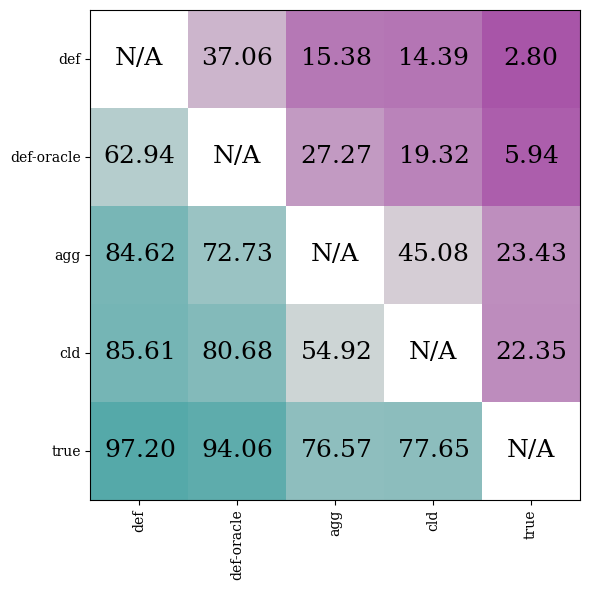

In [35]:
# Initialize DataFrames to hold win counts and total comparisons for each pair (i,j)
win_counts = None
total_counts = None

# Loop over each dataset and each variant (row)
for ds_name, df in df_dict.items():
    df = df["mean"][["def", "def-oracle", "agg", "cld", "true"]][1:]
    if win_counts is None or total_counts is None:
        # Initialize DataFrames to hold win counts and total comparisons for each pair (i,j)
        win_counts = pd.DataFrame(0, index=df.columns, columns=df.columns, dtype=float)
        total_counts = pd.DataFrame(0, index=df.columns, columns=df.columns, dtype=float)
    for idx, row in df.iterrows():
        for i in df.columns:
            for j in df.columns:
                # Only compare if both values are not NaN
                if pd.notnull(row[i]) and pd.notnull(row[j]):
                    total_counts.loc[i, j] += 1
                    if row[i] < row[j]:
                        win_counts.loc[i, j] += 1
                    elif row[i] == row[j]:
                        win_counts.loc[i, j] += 0.5

# Compute winning percentage matrix (expressed as a percentage)
winning_percentage = win_counts / total_counts * 100

np.fill_diagonal(winning_percentage.values, np.nan)
plt.figure(figsize=(6, 6))
plt.imshow(100-winning_percentage, cmap=custom_cmap, vmin=0, vmax=100, alpha=0.7)
for i in range(winning_percentage.shape[0]):
    for j in range(winning_percentage.shape[1]):
        formatted_text = r'${:.2f}$'.format(winning_percentage.iloc[i, j]).replace("$nan$", "N/A")
        plt.text(j, i, formatted_text, ha="center", va="center", color="black", fontsize=18)#, bbox=dict(facecolor='white', edgecolor='none', pad=0))
plt.xticks(np.arange(len(winning_percentage)), winning_percentage.index.values, rotation=90)
plt.yticks(np.arange(len(winning_percentage)), winning_percentage.index.values)
#plt.colorbar()
plt.tight_layout()
plt.savefig(f"winning_matrix_{LOSS_FUNC}.pdf")
plt.show()

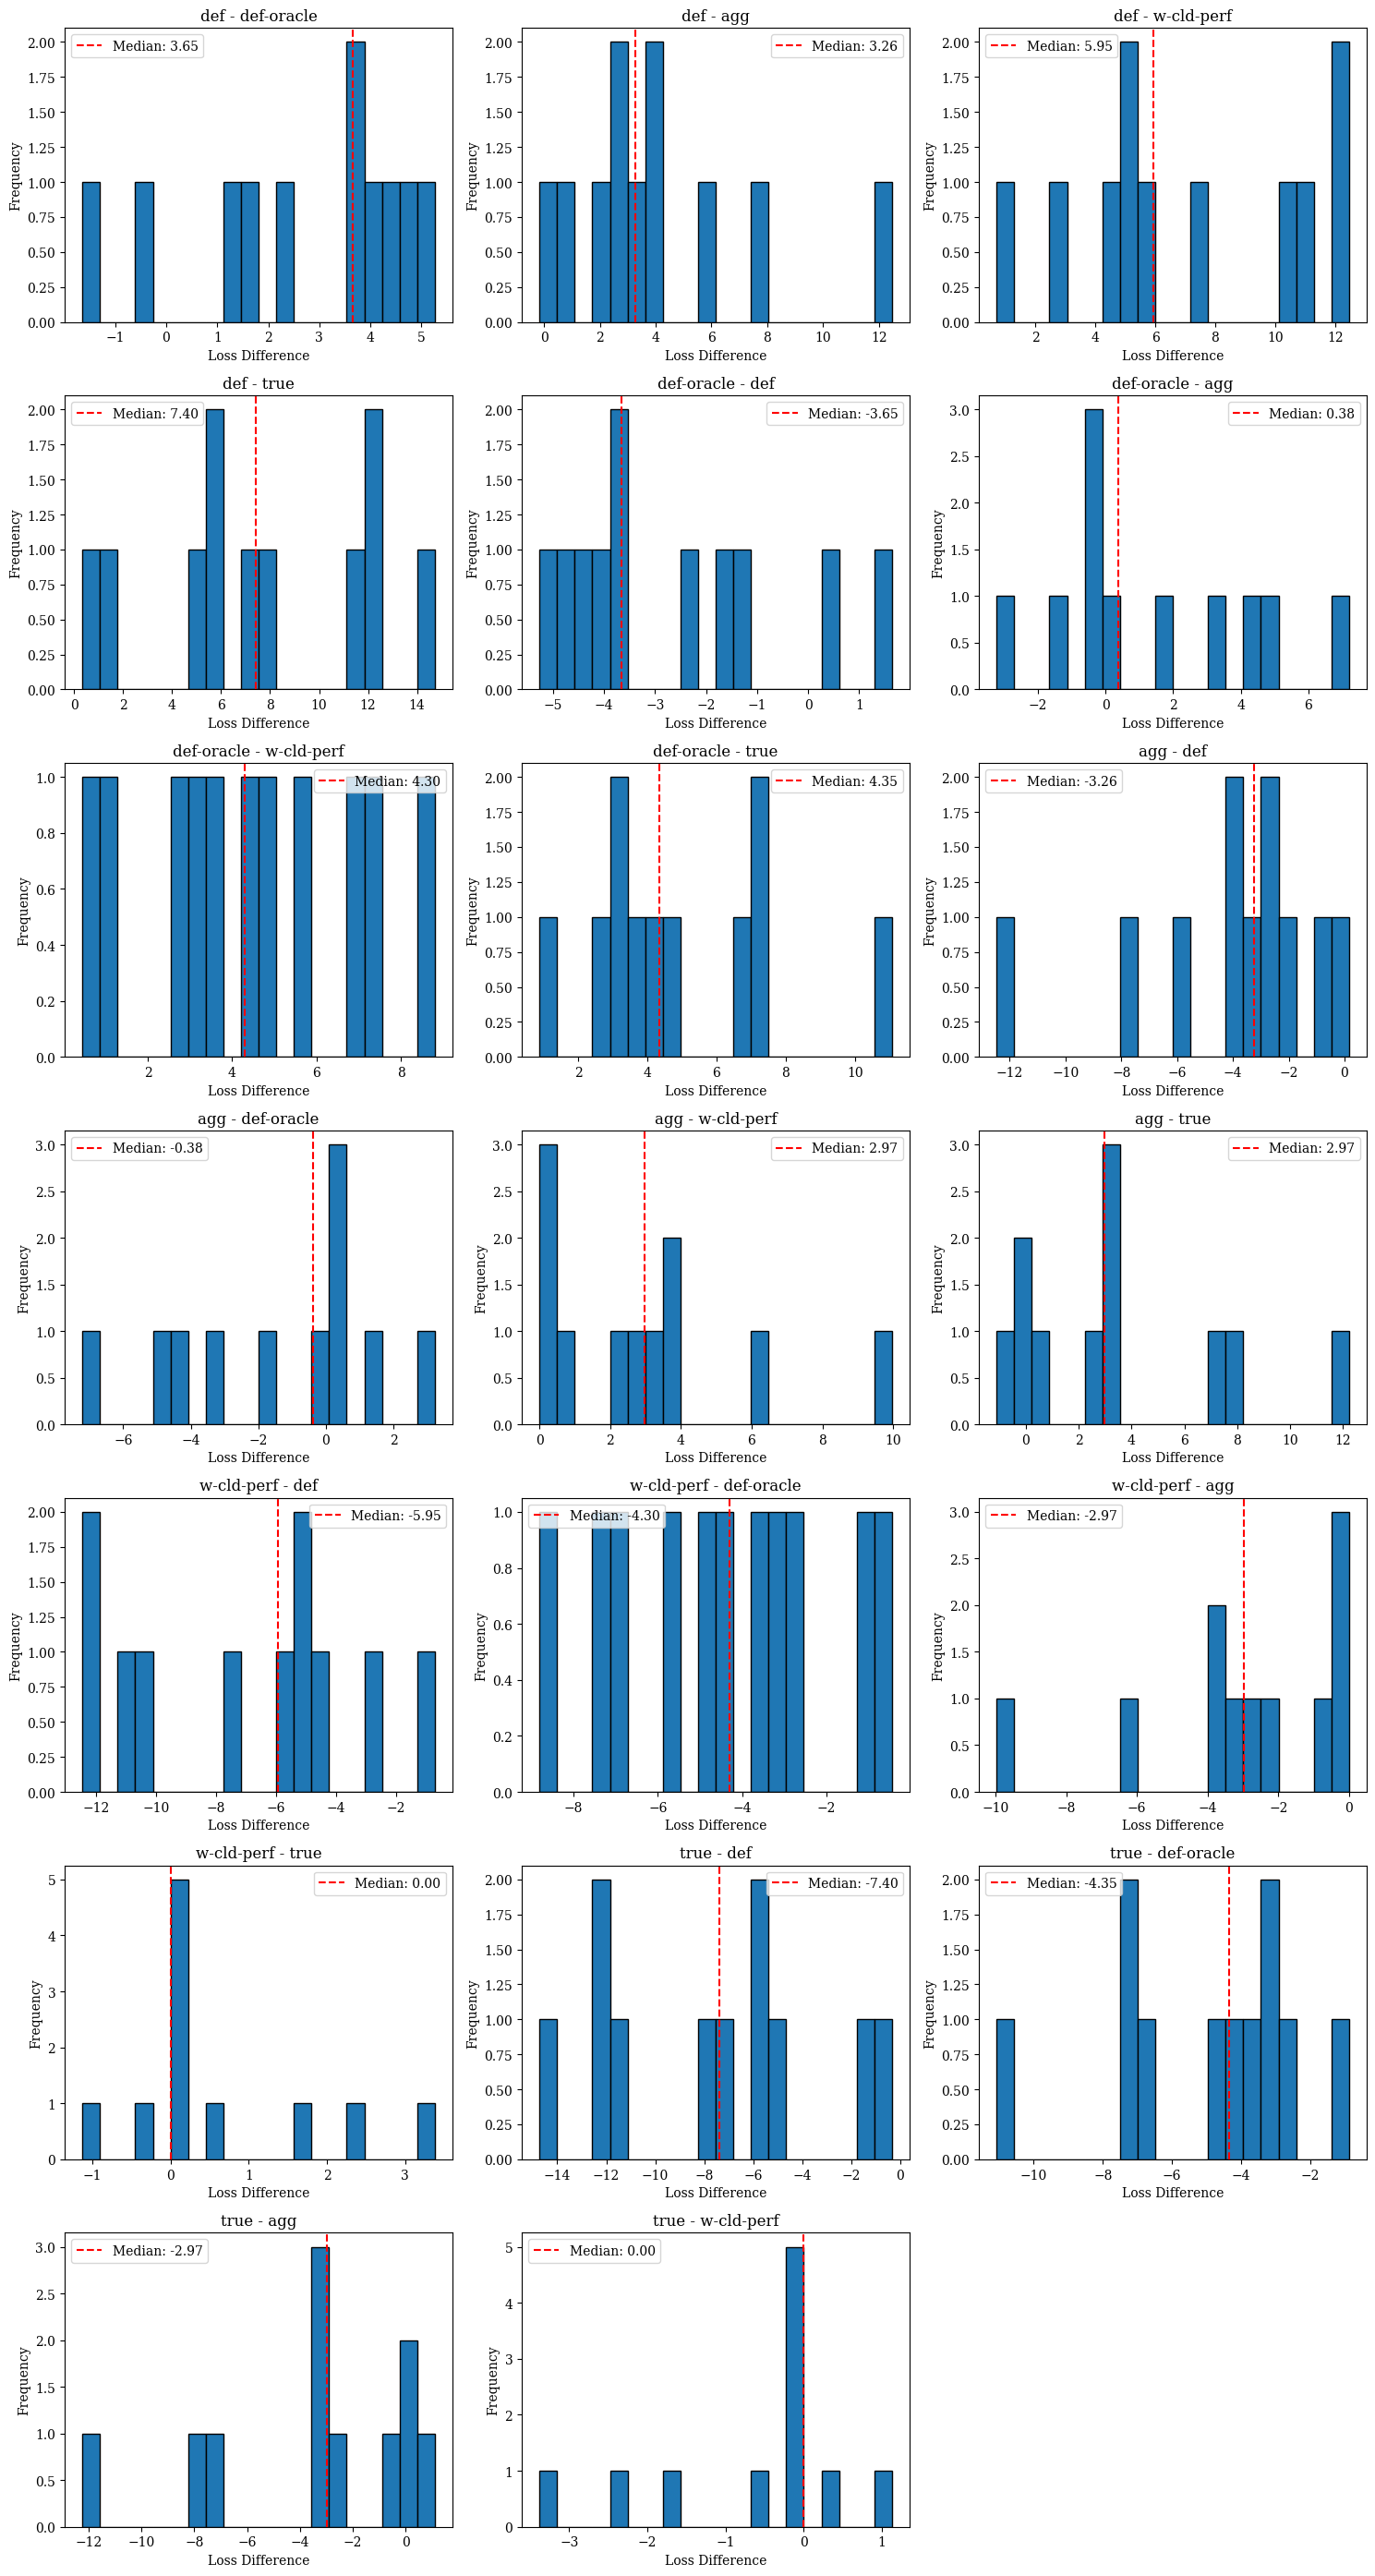

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assume data_dict is your dictionary: {data_set_name: data_frame}
# Each data_frame has loss values with dataset variants as indices and approaches as columns.
approaches = ["def", "def-oracle", "agg", "w-cld-perf", "true"]

# Initialize a dictionary to store differences for each ordered pair (i, j)
# We compute diff = loss[i] - loss[j]
diffs = {}
for i in approaches:
    for j in approaches:
        if i != j:
            diffs[(i, j)] = []

# Loop over each dataset and each variant to compute differences
for ds_name, df in df_dict.items():
    df = df["mean"][["def", "def-oracle", "agg", "w-cld-perf", "true"]][1:]
    for idx, row in df.iterrows():
        for i in approaches:
            for j in approaches:
                if idx != "madl":
                    continue
                if i != j and pd.notnull(row[i]) and pd.notnull(row[j]):
                    diffs[(i, j)].append(row[i] - row[j])

# Plot a grid of histograms for each pair of approaches
n_pairs = len(diffs)
n_cols = 3  # for example, 3 columns in the grid
n_rows = (n_pairs + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # flatten to iterate over them easily

for ax, ((i, j), diff_list) in zip(axes, diffs.items()):
    # Plot histogram for the pair (i, j)
    ax.hist(diff_list, bins=20, edgecolor='k')
    # Draw a vertical line at the median difference
    median_val = np.median(diff_list)
    ax.axvline(median_val, color='red', linestyle='dashed', linewidth=1.5, label=f'Median: {median_val:.2f}')
    ax.set_title(f"{i} - {j}")
    ax.set_xlabel("Loss Difference")
    ax.set_ylabel("Frequency")
    ax.legend()

# Remove any unused subplots if the grid has extra axes
for k in range(len(diffs), len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()
